<a href="https://colab.research.google.com/github/JG-geek/Diffusion_Models/blob/main/deblurring_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup and imports

In [1]:
%pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## load dataset

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.91MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.44MB/s]


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 5, 8, 7, 0, 4, 8, 2])


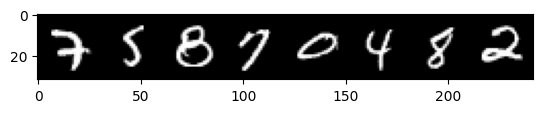

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(train_dataloader))
print('Input shape:', images.shape)
print('Labels:', labels)
plt.imshow(torchvision.utils.make_grid(images)[0], cmap='grey');

## UNet2DModel
(from diffusers library)

In [16]:
model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1,
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

In [17]:
## sanity check
model.to(device)
input = torch.randn(8, 1, 28, 28).to(device)
output = model(input, 0)
print('Output shape:', output.sample.shape)

Output shape: torch.Size([8, 1, 28, 28])


## corrrupt the data

In [18]:
import numpy as np
import cv2  # OpenCV for image blurring

def smooth_gaussian(image, kernel_size=5, iterations=3):
    """
    Apply Gaussian blurring multiple times to smooth the image more aggressively.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - kernel_size: Size of the Gaussian kernel.
    - iterations: Number of times to apply the blur.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    image_np = image.cpu().numpy().squeeze()  # Move to CPU before converting
    for _ in range(iterations):  # Apply multiple blurring passes
        image_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(image_np).unsqueeze(0).to(image.device)  # Convert back to tensor and move to original device

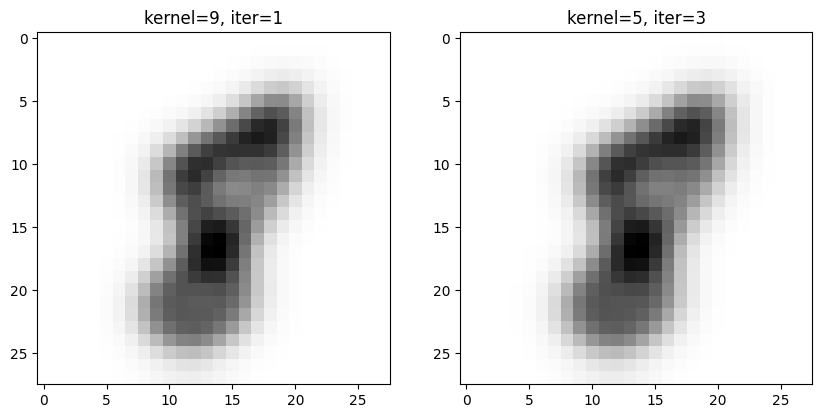

In [19]:
smoothed_image = smooth_gaussian(images[6], 9, 1)
smoothed_image2 = smooth_gaussian(images[6], 5, 3)
# show 2 images side by side
# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(smoothed_image.cpu().squeeze(), cmap='Greys')
axes[0].set_title('kernel=9, iter=1')

axes[1].imshow(smoothed_image2.cpu().squeeze(), cmap='Greys')
axes[1].set_title('kernel=5, iter=3')

plt.show()

100%|██████████| 469/469 [01:46<00:00,  4.41it/s]


Finished epoch 0. Average loss for this epoch: 0.016552


100%|██████████| 469/469 [01:46<00:00,  4.41it/s]


Finished epoch 1. Average loss for this epoch: 0.003308


100%|██████████| 469/469 [01:46<00:00,  4.41it/s]


Finished epoch 2. Average loss for this epoch: 0.002605


100%|██████████| 469/469 [01:46<00:00,  4.42it/s]


Finished epoch 3. Average loss for this epoch: 0.002216


100%|██████████| 469/469 [01:46<00:00,  4.41it/s]

Finished epoch 4. Average loss for this epoch: 0.001974


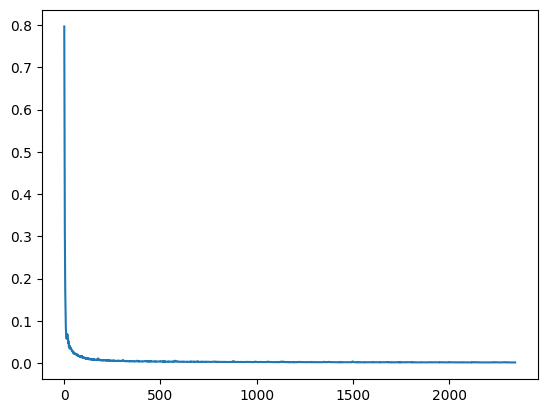

In [20]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Our network
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)

        blurred_x = torch.stack([smooth_gaussian(img,5,3) for img in x])
        blurred_x = blurred_x.to(device)

        # noise = torch.randn_like(x)
        # timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        # noisy_x = noise_scheduler.add_noise(x, noise, timestep)

        # Get the model prediction
        pred = model(blurred_x, 0).sample # using timestep = 0 always

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the input

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [10]:
# Load the MNIST test dataset
mnist_test = torchvision.datasets.MNIST(root="mnist/", train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
# Load test dataset
test_loader = DataLoader(mnist_test, batch_size=256, shuffle=True)  # Larger batch to ensure all labels exist
test_images, test_labels = next(iter(test_loader))  # Get a batch of images and labels


torch.Size([80, 1, 28, 28])
torch.Size([96, 1, 28, 28])


(np.float64(-0.5), np.float64(241.5), np.float64(301.5), np.float64(-0.5))

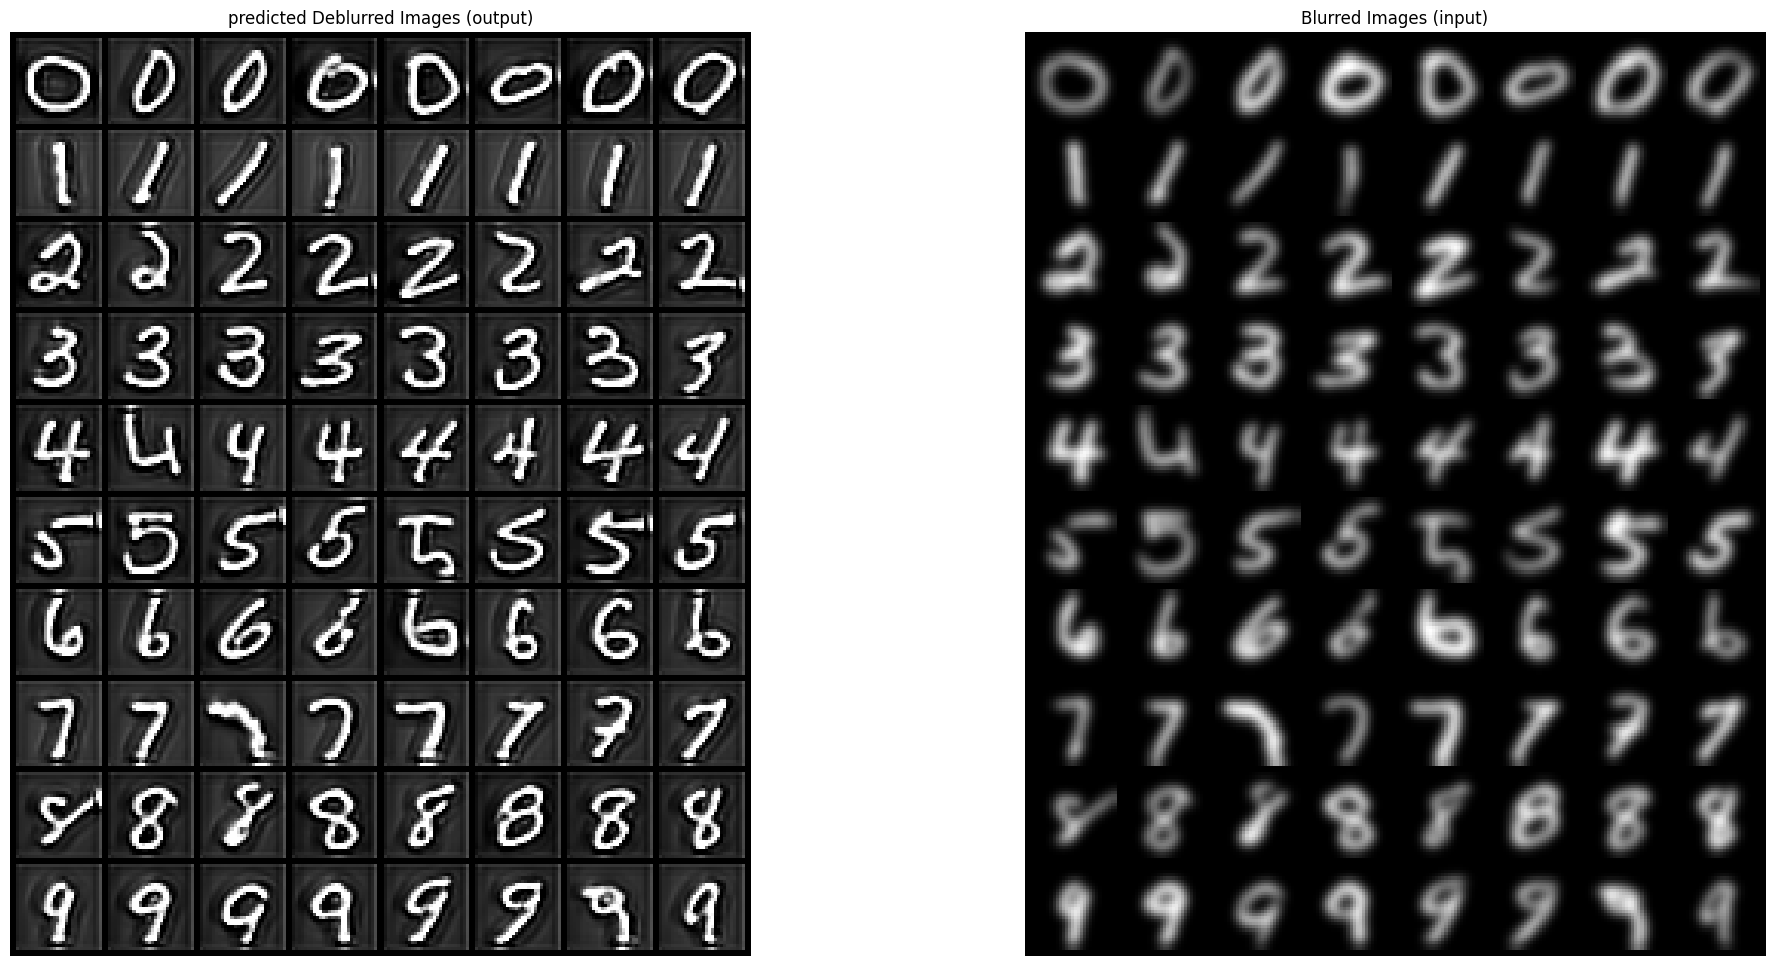

In [21]:
# Move data to device
test_images = test_images
test_labels = test_labels

# Select images corresponding to y (ensuring the order matches)
selected_images = []
# Iterate over labels 0 to 9
for label in range(10):
    # Get all indices where the test label matches the current label
    indices = (test_labels == label).nonzero(as_tuple=True)[0]
    # Shuffle and take 8 indices (or take the first 8 if order doesn't matter)
    selected = indices[torch.randperm(len(indices))][:8]
    # Append the corresponding images
    for idx in selected:
        selected_images.append(test_images[idx])

selected_images = torch.stack(selected_images)  # Shape will be (80, 1, 28, 28)

blurred_x = torch.stack([smooth_gaussian(img,5,3) for img in selected_images])  # Blur them
print(blurred_x.shape)
print(x.shape)
blurred_x = blurred_x.to(device)
# # Sampling loop
# for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # t = t.expand(x.shape[0])  # Ensure `t` matches batch size (80)

# Get model pred
model.eval()
with torch.no_grad():
    x_hat = model(blurred_x, 0).sample  # Again, note that we pass in our labels y

    # Update sample with step
    # x = noise_scheduler.step(residual, t, x).prev_sample

# Convert tensors to grid format for visualization
generated_grid = torchvision.utils.make_grid(x_hat.detach().cpu().clip(-1, 1), nrow=8, normalize=True)
blurred_grid = torchvision.utils.make_grid(blurred_x.detach().cpu(), nrow=8, normalize=True)

# Create figure and show images
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Show generated images
axes[0].imshow(generated_grid.permute(1, 2, 0), cmap='Greys')
axes[0].set_title("predicted Deblurred Images (output)")
axes[0].axis("off")

# Show blurred conditioning images
axes[1].imshow(blurred_grid.permute(1, 2, 0), cmap='Greys')
axes[1].set_title("Blurred Images (input)")
axes[1].axis("off")

Pixel value range before normalization: -1.0 1.0


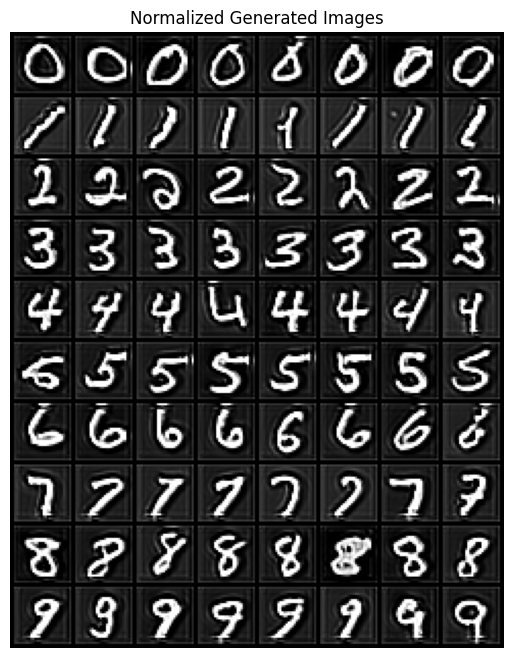

In [14]:
# Detach, move to CPU, and clip values
x_cpu = x_hat.detach().cpu().clip(-1, 1)

# Compute min and max pixel values from x_cpu
min_val = x_cpu.min().item()
max_val = x_cpu.max().item()
print("Pixel value range before normalization:", min_val, max_val)

# Manually normalize x_cpu using the computed range
x_norm = (x_cpu - min_val) / (max_val - min_val)

# Scale to the range [0, 255]
x_scaled = x_norm * 255

# Optionally, convert to uint8 if you prefer
x_uint8 = x_scaled.to(torch.uint8)

# Generate grid without internal normalization
generated_grid = torchvision.utils.make_grid(x_uint8, nrow=8, normalize=False)

# Display the grid image
plt.figure(figsize=(8, 8))
plt.imshow(generated_grid.permute(1, 2, 0), cmap='Greys')
plt.title("Normalized Generated Images")
plt.axis("off")
plt.show()
